# Obtención de los datos

Usaremos el dataset de trashnet que es un conjunto de datos que tiene alrededor de 2500 imágenes de seis tipos diferentes de basura: vidrio, papel, cartón, plástico, metal y basura.

```consola
git clone https://github.com/garythung/trashnet
```

## Dependencias

In [ ]:
import zipfile
import os
import numpy as np

## Proceso

In [ ]:
# Descomprimir el zip con la data
import zipfile

# Ruta de los datos
ruta_datos: str = './trashnet/data'

# Ruta del archivo zip
ruta_zip: str = './trashnet/data/dataset-resized.zip'

# Crear una instancia de ZipFile
archivo_zip: zipfile.ZipFile = zipfile.ZipFile(ruta_zip, 'r')

# Extraer todos los archivos del archivo zip en la ruta especificada
archivo_zip.extractall(ruta_datos)

# Cerrar el archivo zip
archivo_zip.close()

In [ ]:
import os
import numpy as np

# Rutas para la validación y entrenamiento
ruta_validacion: str = './data/valid'
ruta_entrenamiento: str = './data/train'

# Comprobar si los directorios de validación y entrenamiento existen, si no, se crean
if not os.path.exists(ruta_validacion):
    os.makedirs(ruta_validacion)
if not os.path.exists(ruta_entrenamiento):
    os.makedirs(ruta_entrenamiento)

# Ruta de los datos sin comprimir
ruta_datos_descomprimidos: str = './trashnet/data/dataset-resized'

# Recorrer cada archivo en la ruta de datos descomprimidos
for archivo in os.listdir(ruta_datos_descomprimidos):
    # Se crean nuevos directorios para los datos de entrenamiento y validación
    if archivo != '.DS_Store':
        if not os.path.exists(os.path.join(ruta_entrenamiento, archivo)):
            os.makedirs(os.path.join(ruta_entrenamiento, archivo))
        if not os.path.exists(os.path.join(ruta_validacion, archivo)):
            os.makedirs(os.path.join(ruta_validacion, archivo))

# Volver a recorrer cada archivo en la ruta de datos descomprimidos
for archivo in os.listdir(ruta_datos_descomprimidos):
    if archivo != '.DS_Store':
        # Extraer el 20% de las imágenes para la validación (siguiendo la "regla" del 80/20)
        for subarchivo in os.listdir(os.path.join(ruta_datos_descomprimidos, archivo)):
            if subarchivo != '.DS_Store':
                if np.random.rand(1) < 0.2:
                    os.rename(os.path.join(ruta_datos_descomprimidos, archivo, subarchivo), os.path.join(ruta_validacion, archivo, subarchivo))
                else:
                    os.rename(os.path.join(ruta_datos_descomprimidos, archivo, subarchivo), os.path.join(ruta_entrenamiento, archivo, subarchivo))


Verificamos que cada clase tenga la misma cantidad de imágenes

In [ ]:
import os

# Directorio raíz
directorio_raiz = "./data/"

# Extensión de imagen (cambiar si es necesario)
extension_imagen = ".jpg"

# Subdirectorios de entrenamiento y validación
subdirectorios_entrenamiento = [os.path.join(directorio_raiz, "train", subdirectorio) for subdirectorio in os.listdir(os.path.join(directorio_raiz, "train"))]
subdirectorios_validacion = [os.path.join(directorio_raiz, "valid", subdirectorio) for subdirectorio in os.listdir(os.path.join(directorio_raiz, "valid"))]

# Contar el mínimo número de imágenes en los subdirectorios de entrenamiento y validación
minimo_imagenes_entrenamiento = min([len([archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)]) for subdirectorio in subdirectorios_entrenamiento])
minimo_imagenes_validacion = min([len([archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)]) for subdirectorio in subdirectorios_validacion])

# Eliminar imágenes adicionales en los subdirectorios de entrenamiento
for subdirectorio in subdirectorios_entrenamiento:
    archivos_imagen = [archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)]
    conteo_imagenes = len(archivos_imagen)
    diferencia = conteo_imagenes - minimo_imagenes_entrenamiento

    for i in range(diferencia):
        imagen_a_eliminar = archivos_imagen[i]
        ruta_imagen_a_eliminar = os.path.join(subdirectorio, imagen_a_eliminar)
        os.remove(ruta_imagen_a_eliminar)

    conteo_imagenes_restantes = len([archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)])
    print(f"Cantidad de imágenes restantes en {subdirectorio}: {conteo_imagenes_restantes}")

# Eliminar imágenes adicionales en los subdirectorios de validación
for subdirectorio in subdirectorios_validacion:
    archivos_imagen = [archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)]
    conteo_imagenes = len(archivos_imagen)
    diferencia = conteo_imagenes - minimo_imagenes_validacion

    for i in range(diferencia):
        imagen_a_eliminar = archivos_imagen[i]
        ruta_imagen_a_eliminar = os.path.join(subdirectorio, imagen_a_eliminar)
        os.remove(ruta_imagen_a_eliminar)

    conteo_imagenes_restantes = len([archivo for archivo in os.listdir(subdirectorio) if archivo.endswith(extension_imagen)])
    print(f"Cantidad de imágenes restantes en {subdirectorio}: {conteo_imagenes_restantes}")




# Desarrollo

### Dependencias

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from keras.models import load_model
from keras import regularizers

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2023-05-24 01:50:11.366484: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 01:50:11.393224: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 01:50:11.393748: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 01:50:12.104432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Preprocesamiento de los datos

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generador de datos para el conjunto de entrenamiento
generador_entrenamiento: ImageDataGenerator = ImageDataGenerator(
    rescale=1.0/255.0,
    width_shift_range=0.3,
    height_shift_range=0.3,
    rotation_range=30,
    horizontal_flip=True,
    fill_mode='nearest',
    shear_range=0.3,
    zoom_range=0.4
)
    
# Generador de datos para el conjunto de validación
generador_validacion: ImageDataGenerator = ImageDataGenerator(rescale=1./255)

# Crear generadores de datos para el conjunto de entrenamiento y validación
generador_entrenamiento_data = generador_entrenamiento.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=True  # Mezclar los datos de entrenamiento
)

generador_validacion_data = generador_validacion.flow_from_directory(
    validation_path,
    target_size=(150, 150),
    batch_size=160,
    class_mode='categorical',
    shuffle=False  # No mezclar los datos de validación
)


Mostramos algunas de las imagenes post-procesamiento

In [ ]:
import matplotlib.pyplot as plt

# Obtener un lote de imágenes y etiquetas del generador de entrenamiento
imagenes, etiquetas = next(generador_entrenamiento_data)

# Definir los nombres de las clases en el mismo orden que se utilizó al crear el generador
nombres_clases = ['cartón', 'vidrio', 'metal', 'papel', 'plástico', 'basura']

# Mostrar las primeras 20 imágenes
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(imagenes[i])
    plt.title(nombres_clases[etiquetas[i].argmax()])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Creación del modelo	

Utilizamos el modelo base de ResNet101V2  y le hacemos un fine-tuning para que se adapte a nuestro problema.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Crear un modelo base utilizando un modelo pre-entrenado ResNet101V2
modelo_base = tf.keras.applications.ResNet101V2(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

# Congelar las capas pre-entrenadas
for capa in modelo_base.layers:
    capa.trainable = False

# Agregar nuevas capas encima del modelo base
x = modelo_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
# agregar otra capa
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)
predicciones = layers.Dense(6, activation='softmax')(x)

# Definir el modelo
modelo = tf.keras.models.Model(inputs=modelo_base.input, outputs=predicciones)

# Compilar el modelo con una tasa de aprendizaje más baja
modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Imprimir un resumen del modelo
modelo.summary()

### Pre-ajuste

In [ ]:
import tensorflow as tf

# Definir el callback de EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Pasar el callback al método fit
historial_pre_entrenamiento = modelo.fit(
    generador_entrenamiento_data,
    validation_data=generador_validacion_data,
    epochs=100,
    callbacks=[early_stop]
)

### Fine-tuning

In [ ]:
# Descongelar las últimas capas del modelo base
for capa in modelo_base.layers[-20:]:  # Aumentar el número de capas a afinar
    if not isinstance(capa, layers.BatchNormalization):  # No aplicar regularización a las capas BatchNormalization
        capa.kernel_regularizer = regularizers.l2(0.01)  # Agregar regularización L2
    capa.trainable = True

# Recompilar el modelo (necesario después de cambiar la trainabilidad de las capas)
modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),  # Experimentar con la tasa de aprendizaje
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Definir el callback de EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Continuar entrenando el modelo con el afinamiento
historia = modelo.fit(
    generador_entrenamiento_data,
    validation_data=generador_validacion_data,
    epochs=100,
    callbacks=[early_stop]
)

## Post-entrenamiento

In [72]:
# Definimos una ruta para guardar el modelo
modelo_guardado = './model/ResNet101V2_TrashClassifierV2.h5'

In [ ]:
import os

# Verificar si el directorio 'model' existe, si no, se crea
if not os.path.exists('model'):
    os.makedirs('model')

# Guardar el modelo en el directorio especificado
modelo.save(modelo_guardado)

In [73]:
from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo especificado
modelo = load_model(modelo_guardado)

# Mostrar un resumen del modelo cargado
modelo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

In [ ]:
# Obtener las métricas de precisión y pérdida del historial de entrenamiento
precision_entrenamiento = historia.history['accuracy']
precision_validacion = historia.history['val_accuracy']
perdida_entrenamiento = historia.history['loss']
perdida_validacion = historia.history['val_loss']

# Definir el número de épocas
epocas = range(len(precision_entrenamiento))

# Graficar la precisión de entrenamiento y validación a lo largo de las épocas
plt.plot(epocas, precision_entrenamiento, 'r', label='Precisión de entrenamiento')
plt.plot(epocas, precision_validacion, 'b', label='Precisión de validación')
plt.title('Precisión de entrenamiento y validación')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Graficar la pérdida de entrenamiento y validación a lo largo de las épocas
plt.plot(epocas, perdida_entrenamiento, 'r', label='Pérdida de entrenamiento')
plt.plot(epocas, perdida_validacion, 'b', label='Pérdida de validación')
plt.title('Pérdida de entrenamiento y validación')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obtener las etiquetas de las imágenes de prueba
etiquetas_prueba = generador_validacion_data.classes

# Realizar una predicción
predicciones = modelo.predict(generador_validacion_data)

# Obtener la clase más probable
clases_predichas = np.argmax(predicciones, axis=1)

# Encontrar los índices de los errores
errores = np.where(clases_predichas != etiquetas_prueba)[0]
print("Número de errores = {}/{}".format(len(errores), generador_validacion_data.samples))
precision = (generador_validacion_data.samples - len(errores)) / generador_validacion_data.samples
print("Precisión = ", precision * 100, "%")

# Crear una matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_prueba, clases_predichas)
etiquetas_plot_cm = ['cartón', 'vidrio', 'metal', 'papel', 'plástico', 'basura (misceláneo)']

# Graficar la matriz de confusión
plt.figure(figsize=(10, 10))
sns.heatmap(matriz_confusion, annot=True, cmap='Blues', fmt='g', xticklabels=etiquetas_plot_cm, yticklabels=etiquetas_plot_cm)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img

# Mostrar algunos ejemplos clasificados incorrectamente
for i in range(len(errores)):
    figura, ax = plt.subplots(1, 1)
    clase_predicha = np.argmax(predicciones[errores[i]])
    etiqueta_predicha = etiquetas_plot_cm[clase_predicha]

    titulo = 'Etiqueta original: {}, Predicción: {}, confianza: {:.3f}'.format(
        etiquetas_plot_cm[etiquetas_prueba[errores[i]]], etiqueta_predicha, predicciones[errores[i]][clase_predicha]
    )

    original = load_img('{}/{}'.format(validation_path, generador_validacion_data.filenames[errores[i]]))
    plt.imshow(original)
    plt.title(titulo)
    plt.show()

    if i == 9:
        break


## Pruebas

In [108]:
import cv2
from tensorflow.keras.applications.resnet50 import decode_predictions
from tensorflow.keras.applications.resnet import decode_predictions
from tensorflow.keras.applications.resnet import preprocess_input

classes = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

def generar_mapa_calor_gradcam(img_array, modelo, nombre_ultima_capa_conv=None, indice_prediccion=None):
    # Creamos un modelo que mapea las entradas del modelo a las activaciones de la última capa convolucional y las salidas del modelo original
    modelo_gradcam = tf.keras.models.Model(
        [modelo.inputs], [modelo.get_layer(nombre_ultima_capa_conv).output, modelo.output]
    )

    # Computamos los gradientes de la clase predicha con respecto a las características de salida de la última capa convolucional
    with tf.GradientTape() as cinta:
        salida_ultima_capa_conv, predicciones = modelo_gradcam(img_array)
        if indice_prediccion is None:
            indice_prediccion = tf.argmax(predicciones[0])
        canal_clase = predicciones[:, indice_prediccion]

    # Calculamos el gradiente de la salida de la clase predicha con respecto a la salida de la última capa convolucional
    gradientes = cinta.gradient(canal_clase, salida_ultima_capa_conv)

    # Hacemos un pooling global de los gradientes a través de los ejes (0, 1, 2) para obtener el valor medio de los gradientes para cada canal del feature-map
    gradientes_promedio = tf.reduce_mean(gradientes, axis=(0, 1, 2))

    # Multiplicamos cada canal en el feature-map por "cuánto importa este canal" con respecto a la clase predicha
    salida_ultima_capa_conv = salida_ultima_capa_conv[0]
    mapa_calor = salida_ultima_capa_conv @ gradientes_promedio[..., tf.newaxis]
    mapa_calor = tf.squeeze(mapa_calor)

    # Normalizamos el mapa de calor entre 0 y 1 para su visualización
    mapa_calor = tf.maximum(mapa_calor, 0) / tf.math.reduce_max(mapa_calor)
    return mapa_calor.numpy()

def superponer_mapa_calor(mapa_calor, img, alpha=0.4, colormap=cv2.COLORMAP_VIRIDIS):
    mapa_calor = cv2.resize(mapa_calor, (img.shape[1], img.shape[0]))
    mapa_calor = cv2.applyColorMap(np.uint8(255 * mapa_calor), colormap)
    salida = cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), alpha, mapa_calor, 1 - alpha, 0)
    return salida

def visualizar_gradcam(ruta_imagen, modelo, nombre_ultima_capa_conv='conv5_block3_out'):
    img = image.load_img(ruta_imagen, target_size=(150, 150))
    img_array = preprocess_input(image.img_to_array(img))
    img_array = np.expand_dims(img_array, axis=0)

    predicciones = modelo.predict(img_array)
    mapa_calor = generar_mapa_calor_gradcam(img_array, modelo, nombre_ultima_capa_conv)
    mapa_calor = cv2.resize(mapa_calor, (img.size[0], img.size[1]))

    img = np.asarray(img)
    imagen_superpuesta = superponer_mapa_calor(mapa_calor, img)
    
    plt.matshow(imagen_superpuesta)
    return classes[np.argmax(predicciones[0])], max(predicciones[0])

In [109]:
ruta_imagen = './data/prueba_3.jpg'

1/1 [==============================] - 0s 86ms/step


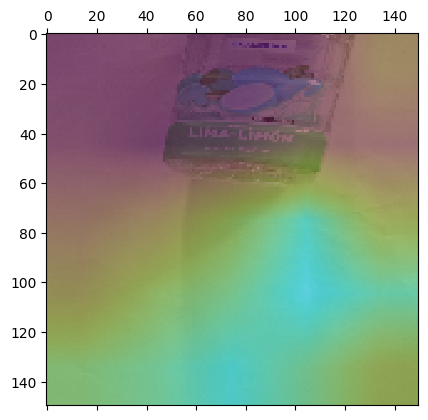

In [110]:
# Ahora puedes llamar a la función con el modelo y la ruta de la imagen como argumentos
prediccion, probabilidad = visualizar_gradcam(ruta_imagen, model)

In [111]:
prediccion, probabilidad

('plastic', 0.92723584)

In [43]:
clase_predicha, probabilidad = predecir_imagen(modelo, ruta_imagen)
print("Clase predicha:", clase_predicha)
print("Probabilidad:", probabilidad)

ValueError: No such layer: avg_pool. Existing layers are: ['input_1', 'conv1_pad', 'conv1_conv', 'pool1_pad', 'pool1_pool', 'conv2_block1_preact_bn', 'conv2_block1_preact_relu', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_pad', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_out', 'conv2_block2_preact_bn', 'conv2_block2_preact_relu', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_pad', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_out', 'conv2_block3_preact_bn', 'conv2_block3_preact_relu', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_pad', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'max_pooling2d', 'conv2_block3_3_conv', 'conv2_block3_out', 'conv3_block1_preact_bn', 'conv3_block1_preact_relu', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_pad', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_out', 'conv3_block2_preact_bn', 'conv3_block2_preact_relu', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_pad', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_out', 'conv3_block3_preact_bn', 'conv3_block3_preact_relu', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_pad', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_out', 'conv3_block4_preact_bn', 'conv3_block4_preact_relu', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_pad', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'max_pooling2d_1', 'conv3_block4_3_conv', 'conv3_block4_out', 'conv4_block1_preact_bn', 'conv4_block1_preact_relu', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_pad', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_out', 'conv4_block2_preact_bn', 'conv4_block2_preact_relu', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_pad', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_out', 'conv4_block3_preact_bn', 'conv4_block3_preact_relu', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_pad', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_out', 'conv4_block4_preact_bn', 'conv4_block4_preact_relu', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_pad', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_out', 'conv4_block5_preact_bn', 'conv4_block5_preact_relu', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_pad', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_out', 'conv4_block6_preact_bn', 'conv4_block6_preact_relu', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_pad', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_out', 'conv4_block7_preact_bn', 'conv4_block7_preact_relu', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_pad', 'conv4_block7_2_conv', 'conv4_block7_2_bn', 'conv4_block7_2_relu', 'conv4_block7_3_conv', 'conv4_block7_out', 'conv4_block8_preact_bn', 'conv4_block8_preact_relu', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_pad', 'conv4_block8_2_conv', 'conv4_block8_2_bn', 'conv4_block8_2_relu', 'conv4_block8_3_conv', 'conv4_block8_out', 'conv4_block9_preact_bn', 'conv4_block9_preact_relu', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_pad', 'conv4_block9_2_conv', 'conv4_block9_2_bn', 'conv4_block9_2_relu', 'conv4_block9_3_conv', 'conv4_block9_out', 'conv4_block10_preact_bn', 'conv4_block10_preact_relu', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_pad', 'conv4_block10_2_conv', 'conv4_block10_2_bn', 'conv4_block10_2_relu', 'conv4_block10_3_conv', 'conv4_block10_out', 'conv4_block11_preact_bn', 'conv4_block11_preact_relu', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_pad', 'conv4_block11_2_conv', 'conv4_block11_2_bn', 'conv4_block11_2_relu', 'conv4_block11_3_conv', 'conv4_block11_out', 'conv4_block12_preact_bn', 'conv4_block12_preact_relu', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_pad', 'conv4_block12_2_conv', 'conv4_block12_2_bn', 'conv4_block12_2_relu', 'conv4_block12_3_conv', 'conv4_block12_out', 'conv4_block13_preact_bn', 'conv4_block13_preact_relu', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_pad', 'conv4_block13_2_conv', 'conv4_block13_2_bn', 'conv4_block13_2_relu', 'conv4_block13_3_conv', 'conv4_block13_out', 'conv4_block14_preact_bn', 'conv4_block14_preact_relu', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_pad', 'conv4_block14_2_conv', 'conv4_block14_2_bn', 'conv4_block14_2_relu', 'conv4_block14_3_conv', 'conv4_block14_out', 'conv4_block15_preact_bn', 'conv4_block15_preact_relu', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_pad', 'conv4_block15_2_conv', 'conv4_block15_2_bn', 'conv4_block15_2_relu', 'conv4_block15_3_conv', 'conv4_block15_out', 'conv4_block16_preact_bn', 'conv4_block16_preact_relu', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_pad', 'conv4_block16_2_conv', 'conv4_block16_2_bn', 'conv4_block16_2_relu', 'conv4_block16_3_conv', 'conv4_block16_out', 'conv4_block17_preact_bn', 'conv4_block17_preact_relu', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_pad', 'conv4_block17_2_conv', 'conv4_block17_2_bn', 'conv4_block17_2_relu', 'conv4_block17_3_conv', 'conv4_block17_out', 'conv4_block18_preact_bn', 'conv4_block18_preact_relu', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_pad', 'conv4_block18_2_conv', 'conv4_block18_2_bn', 'conv4_block18_2_relu', 'conv4_block18_3_conv', 'conv4_block18_out', 'conv4_block19_preact_bn', 'conv4_block19_preact_relu', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_pad', 'conv4_block19_2_conv', 'conv4_block19_2_bn', 'conv4_block19_2_relu', 'conv4_block19_3_conv', 'conv4_block19_out', 'conv4_block20_preact_bn', 'conv4_block20_preact_relu', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_pad', 'conv4_block20_2_conv', 'conv4_block20_2_bn', 'conv4_block20_2_relu', 'conv4_block20_3_conv', 'conv4_block20_out', 'conv4_block21_preact_bn', 'conv4_block21_preact_relu', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_pad', 'conv4_block21_2_conv', 'conv4_block21_2_bn', 'conv4_block21_2_relu', 'conv4_block21_3_conv', 'conv4_block21_out', 'conv4_block22_preact_bn', 'conv4_block22_preact_relu', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_pad', 'conv4_block22_2_conv', 'conv4_block22_2_bn', 'conv4_block22_2_relu', 'conv4_block22_3_conv', 'conv4_block22_out', 'conv4_block23_preact_bn', 'conv4_block23_preact_relu', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_pad', 'conv4_block23_2_conv', 'conv4_block23_2_bn', 'conv4_block23_2_relu', 'max_pooling2d_2', 'conv4_block23_3_conv', 'conv4_block23_out', 'conv5_block1_preact_bn', 'conv5_block1_preact_relu', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_pad', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_out', 'conv5_block2_preact_bn', 'conv5_block2_preact_relu', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_pad', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_out', 'conv5_block3_preact_bn', 'conv5_block3_preact_relu', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_pad', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_out', 'post_bn', 'post_relu', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1', 'dropout_1', 'dense_2'].